## Suite of scripts for analyzing MSAs using Singular Value Decomposition - Ras

### Version 0, updated 02-09-2022

#### Written by Gina El Nesr, Autum Koenigs, and Doug Barrick
This generates most of the plots in the paper for Ras.

In [1]:
import os
import cv2
import imageio
import numpy as np
import pandas as pd
import scipy as sp

import Bio
from Bio import SeqIO

import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans

## Parameters & Filenames

In [3]:
# name of MSA alignment
ALIGNMENT = 'RAS_aligned_gapStrip.txt'

# name of protein
PROTEIN_NAME = 'Ras'

# 1 if generating and saving movies (.mp4) generated, 0 if not
MOVIES = 0

#styling
plt.style.use('svd.mplstyle.txt')

## Import Multiple Sequence Alignment

In [4]:
fasta_sequences = SeqIO.parse(open(ALIGNMENT),'fasta')

names = []
sequences = []
count = 0
for fasta in fasta_sequences:
    count += 1
    name, seq = fasta.id, str(fasta.seq)
    names.append(name)
    seq = seq.replace('X', '-')
    sequences.append(seq)

num_seqs = len(sequences)

## One-Hot Encoding Function for Sequences

In [5]:
def ohe(list_residues):

    # dictionary for amino acids to binary representation
    encoder = {'A':'10000000000000000000','C':'01000000000000000000','D':'00100000000000000000',
               'E':'00010000000000000000','F':'00001000000000000000','G':'00000100000000000000',
               'H':'00000010000000000000','I':'00000001000000000000','K':'00000000100000000000',
               'L':'00000000010000000000','M':'00000000001000000000','N':'00000000000100000000',
               'P':'00000000000010000000','Q':'00000000000001000000','R':'00000000000000100000',
               'S':'00000000000000010000','T':'00000000000000001000','V':'00000000000000000100',
               'W':'00000000000000000010','Y':'00000000000000000001','-':'00000000000000000000',
               'Z':'00000000000000000000','B':'00000000000000000000'}
    
    protein = "".join([encoder[R] for R in list_residues])
    
    ohe_list = [int(char) for char in protein]
    
    return ohe_list

## Performing SVD 

In [6]:
ohe_list = []

for seq in sequences:
    ohe_list.append(ohe(seq)) 

F = np.array(ohe_list)
print('F-matrix generated...')

U, S, VT = np.linalg.svd(F)
V = VT.transpose()

print('SVD has been performed.')

SU_df = pd.DataFrame(S*U[:,:len(S)])

F-matrix generated...
SVD has been performed.


## Run this if you want to be sure that the $v_i^{(1)}$ and the $\sigma_1 u_i^{(1)}$ elements are positive.

In [7]:
if np.sum(V[:, 0]) < 0:
    U = -U
    V = -V

## Shuffle the columns of the MSA

In [9]:
def MSA_shuffle(sequences):
    shuffled_MSA_df = pd.DataFrame()
    listed_seqs = []

    for seq in sequences:
        listed_seqs.append(list(seq))

    seq_df = pd.DataFrame(listed_seqs)
    consensus = ''

    for i in range(len(sequences[0])):
        shuffled_MSA_df[i] = np.random.permutation(seq_df[i])
    
    shuffled_MSA_list = []
    for seq_num in range(len(shuffled_MSA_df)):
        sequence = []
        for resi_num in range(len(shuffled_MSA_df.iloc[0])):
            sequence += shuffled_MSA_df[resi_num][seq_num]
        shuffled_MSA_list.append(''.join(sequence))

    return shuffled_MSA_list

In [10]:
shuffled_MSA_sequences = MSA_shuffle(sequences)

## OHE and SVD of shuffled sequences

In [12]:
shuffled_MSA_ohe_list = []

for seq in shuffled_MSA_sequences:
    shuffled_MSA_ohe_list.append(ohe(seq)) 

F_shuffled_MSA = np.array(shuffled_MSA_ohe_list)
print('F-matrix generated...')

U_shuffled_MSA, S_shuffled_MSA, VT_shuffled_MSA = np.linalg.svd(F_shuffled_MSA)
V_shuffled_MSA = VT_shuffled_MSA.transpose()

print('SVD has been performed.')

F-matrix generated...
SVD has been performed.


In [13]:
if np.sum(V_shuffled_MSA[:, 0]) < 0:
    U_shuffled_MSA = -U_shuffled_MSA
    V_shuffled_MSA = -V_shuffled_MSA

## Shuffle the F matrix.
Call it F_shuffled rather than F_shuffled_MSA

In [14]:
F_shuffled = 0*F

for column in range(len(F_shuffled[0,:])):
    F_shuffled[:, column] = np.random.permutation(F[:, column])

In [15]:
U_shuffled_F, S_shuffled_F, VT_shuffled_F = np.linalg.svd(F_shuffled)
V_shuffled_F = VT_shuffled_F.transpose()

print('SVD has been performed.')

SVD has been performed.


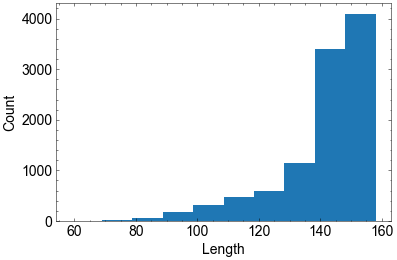

In [79]:
mpl.rc('font', family='Arial', size=14)
labelfont = {'family': 'Arial', 'size': 24}

len_array = np.zeros(len(sequences))

i = 0
for seq in sequences:
    gaps = seq.count('-')
    seq_len = len(seq) - gaps
    len_array[i] = seq_len
    i += 1

plt.hist(len_array)
plt.xlabel('Length')
plt.ylabel('Count');

The correlation coefficient is (0.8491918438989339, 0.0).


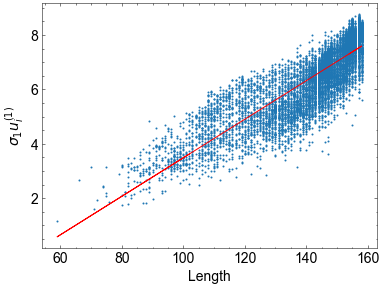

In [81]:
mpl.rc('font', family='Arial', size=14)
labelfont = {'family': 'Arial', 'size': 24}

#Linear regression
m, b = np.polyfit(len_array, S[0]*U[:, 0], 1)
pcc = sp.stats.pearsonr(len_array, S[0]*U[:, 0])
print(f'The correlation coefficient is {pcc}.')

fig1 = plt.figure(figsize=(6, 4.5))

plt.plot(len_array, S[0]*U[:, 0], 'o', markersize = 1)
plt.plot(len_array, m*len_array + b, 'r')
plt.xlabel('Length')
plt.ylabel('$\sigma_1 u_i^{{(1)}}$');
plt.savefig(f'{PROTEIN_NAME}_SigmaU_1_length.pdf')

### Bar plots of singular values

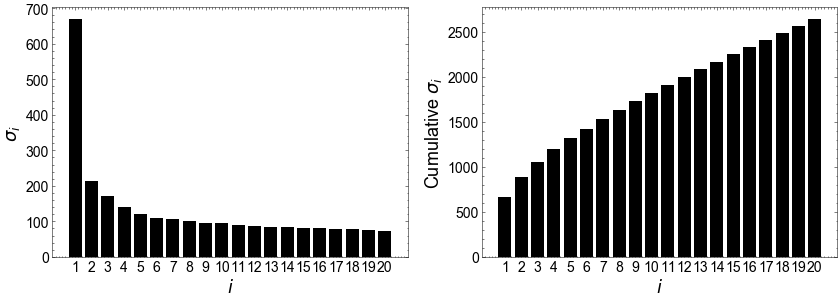

In [8]:
sum_of_sigmas = np.sum(S)
cumsum_of_sigmas = np.cumsum(S)

xticks = []
for num in range(1, 21):
    xticks.append(num)

mpl.rc('font', family='Arial', size=14)
labelfont = {'family': 'Arial', 'size': 24}
    
fig1 = plt.figure(figsize=(12, 4.5))

plt.subplot(1, 2, 1)
plt.bar(np.arange(1, 21), height = S[:20], color='black')
plt.xticks(xticks)
plt.xlabel('$i$', fontsize = 18)
plt.ylabel('$\sigma_i$', fontsize = 18)

plt.subplot(1, 2, 2)
plt.bar(np.arange(1, 21), height = cumsum_of_sigmas[:20], color='black')
plt.xticks(xticks)
plt.xlabel('$i$', fontsize = 18)
plt.ylabel('Cumulative $\sigma_i$', fontsize = 18)

plt.tight_layout()
plt.savefig(f'{PROTEIN_NAME}_sigma_barchart.pdf')

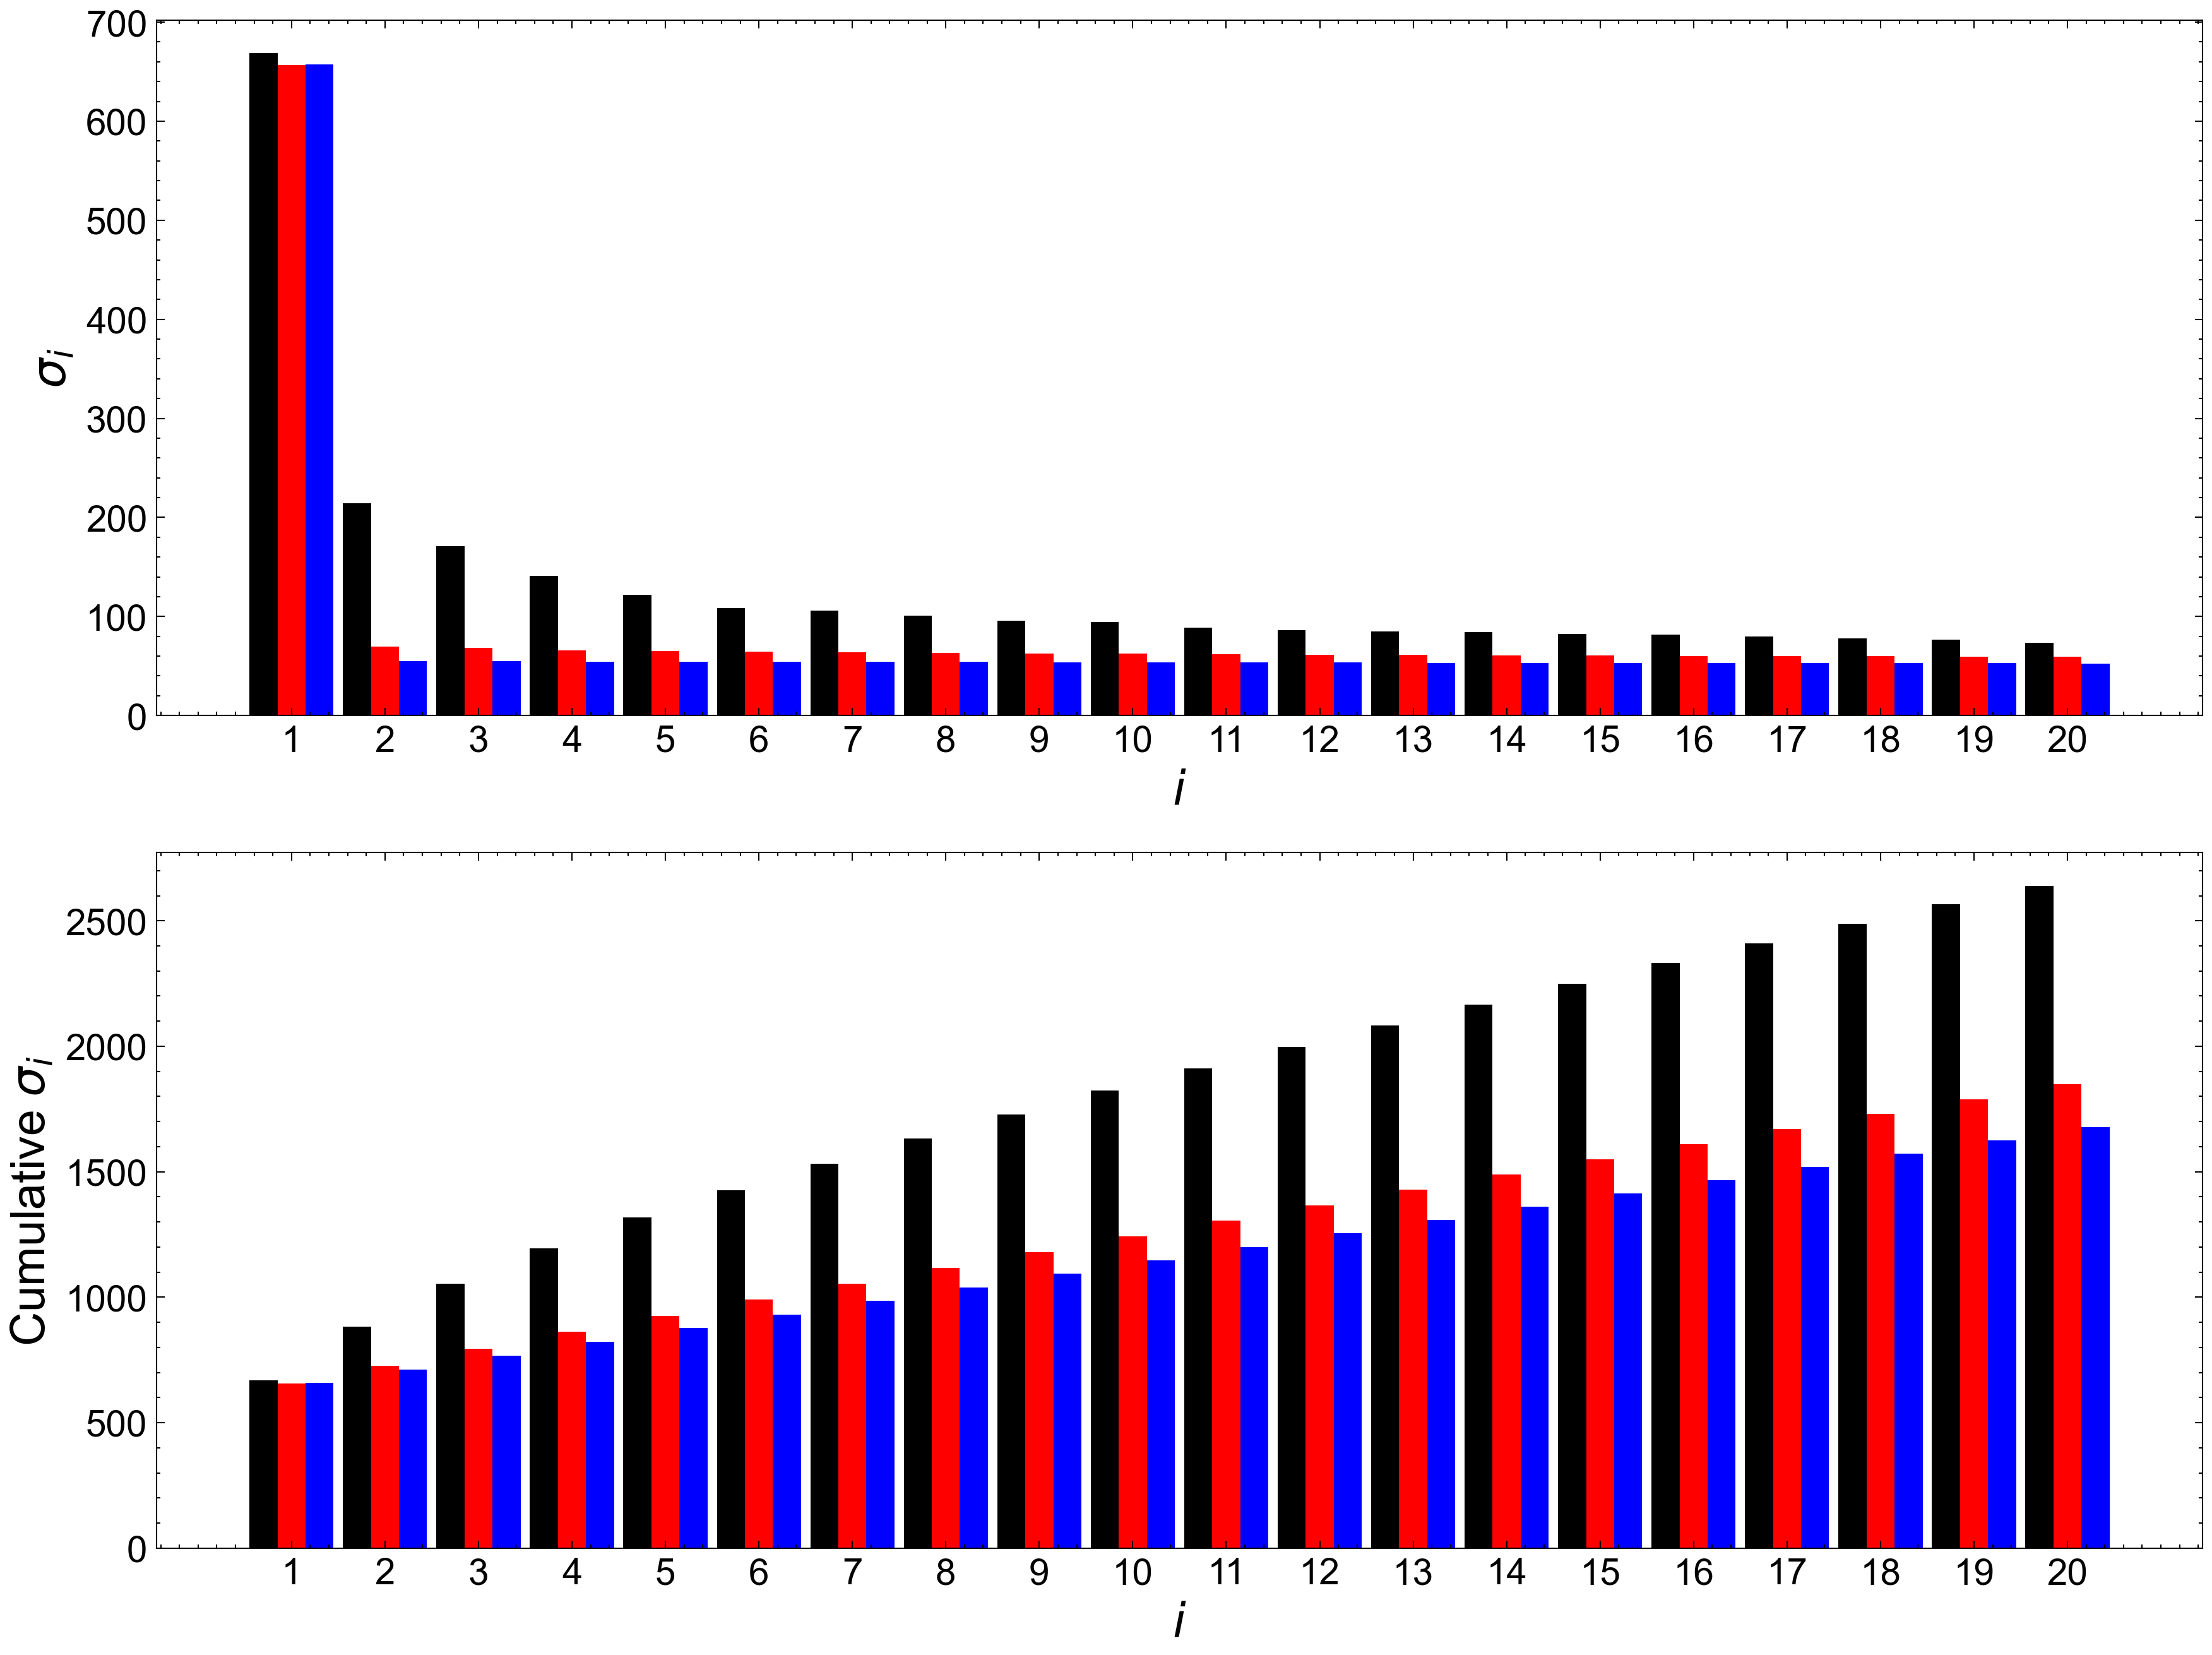

In [16]:
sum_of_sigmas = np.sum(S)
cumsum_of_sigmas = np.cumsum(S)
cumsum_of_sigmas_shuffled_MSA = np.cumsum(S_shuffled_MSA)
cumsum_of_sigmas_shuffled_F = np.cumsum(S_shuffled_F)

xticks = []
for num in range(1, 21):
    xticks.append(num)

mpl.rc('font', family='Arial', size=14)
labelfont = {'family': 'Arial', 'size': 24}

w = 0.3  # the width of the bars

fig1 = plt.figure(figsize=(12, 9), dpi=300)

plt.subplot(2, 1, 1)
plt.bar(np.arange(1, 21) - w, height = S[:20], width=0.3, color='black')
plt.bar(np.arange(1, 21), height = S_shuffled_MSA[:20], width=0.3, color='red')
plt.bar(np.arange(1, 21) + w, height = S_shuffled_F[:20], width=0.3, color='blue')
plt.xticks(xticks)
plt.xlabel('$i$', fontsize = 18)
plt.ylabel('$\sigma_i$', fontsize = 18)

plt.subplot(2, 1, 2)
plt.bar(np.arange(1, 21) - w, height = cumsum_of_sigmas[:20], width=0.3, color='black')
plt.bar(np.arange(1, 21), height = cumsum_of_sigmas_shuffled_MSA[:20], width=0.3, color='red')
plt.bar(np.arange(1, 21) + w, height = cumsum_of_sigmas_shuffled_F[:20], width=0.3, color='blue')
plt.xticks(xticks)
plt.xlabel('$i$', fontsize = 18)
plt.ylabel('Cumulative $\sigma_i$', fontsize = 18)

plt.tight_layout()
plt.savefig(f'{PROTEIN_NAME}_sigma_barchart.pdf')

In [17]:
cumsum_of_sigmas

array([  668.53205026,   883.04416578,  1054.11791624, ...,
       37273.64307738, 37273.64307738, 37273.64307738])

In [18]:
cumsum_of_sigmas_shuffled_MSA

array([  657.00246719,   726.84622261,   795.45523974, ...,
       41016.79433873, 41016.79433873, 41016.79433873])

In [19]:
cumsum_of_sigmas_shuffled_F

array([  657.43651366,   712.57447238,   767.29549624, ...,
       42053.71628619, 42053.71628619, 42053.71628619])

## Histograms of $\sigma_k u_i^{(k)}$ values.

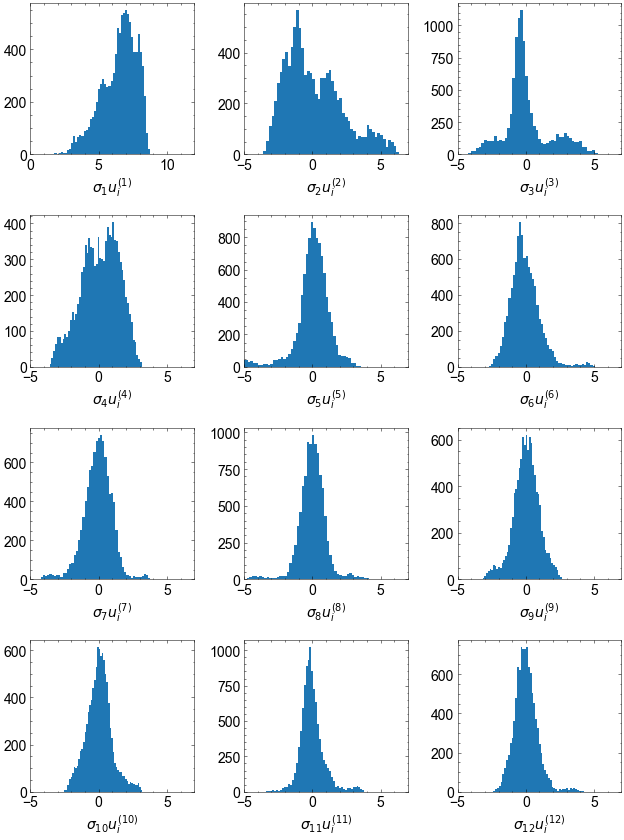

In [20]:
fig = plt.figure(figsize=(9, 12))

i = 0
while i < 12:
    plt.subplot(4, 3, i+1)
    plt.hist(S[i]*U[:, i], bins = 50)
    plt.xlabel(f'$\sigma_{{{i+1}}} u_i^{{({i+1})}}$')
    if i == 0:
        plt.xlim((0, 12))
    else:
        plt.xlim((-5, 7))
    i+= 1

plt.tight_layout()
plt.savefig('Ras_sigmau_histograms.pdf')

## Histograms of $v_i^{(k)}$ values.

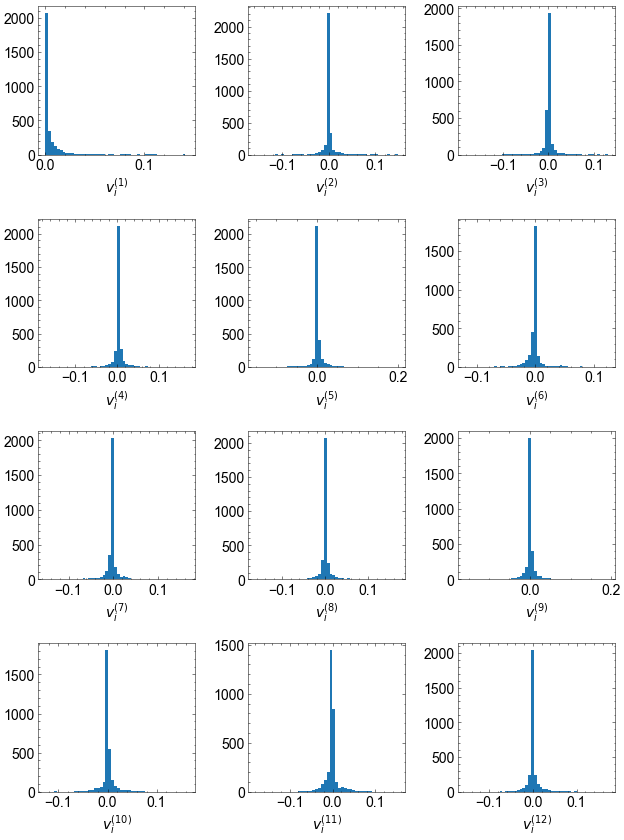

In [21]:
fig = plt.figure(figsize=(9, 12))

i = 0
while i < 12:
    plt.subplot(4, 3, i+1)
    plt.hist(V[:, i], bins = 50)
    plt.xlabel(f'$v_i^{{({i+1})}}$')
    #if i == 0:
        #plt.xlim((-12, 0))
    #else:
        #plt.xlim((-7, 5))
    i+= 1

plt.tight_layout()
plt.savefig('Ras_v_histograms.pdf')

## Plotting Sequences in SVD Space

### 2D plots of sequences along the first three singular axes

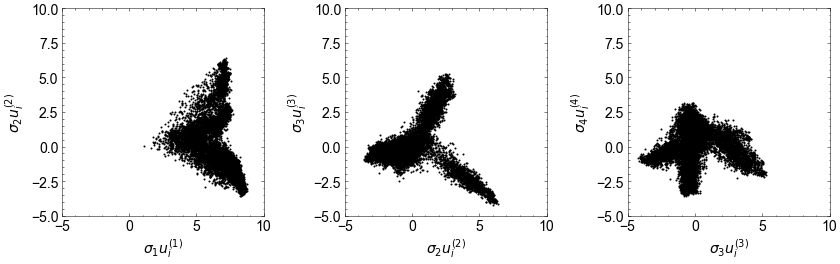

In [24]:
fig = plt.figure(figsize=(12,4))

for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.xlim(-5, 10)
    plt.ylim(-5, 10)
    plt.plot(S[i]*U[:,i], S[i+1]*U[:,i+1], 'ok',markersize=1)
    plt.xlabel(f'$\sigma_{i+1} u_i^{{({i+1})}}$')
    plt.ylabel(f'$\sigma_{i+2} u_i^{{({i+2})}}$')

plt.tight_layout()
plt.savefig(f'{PROTEIN_NAME}_SigmaU_3_2dplots_nocluster.pdf')

### 2D plots on the first 13 singular axes (12 plots)

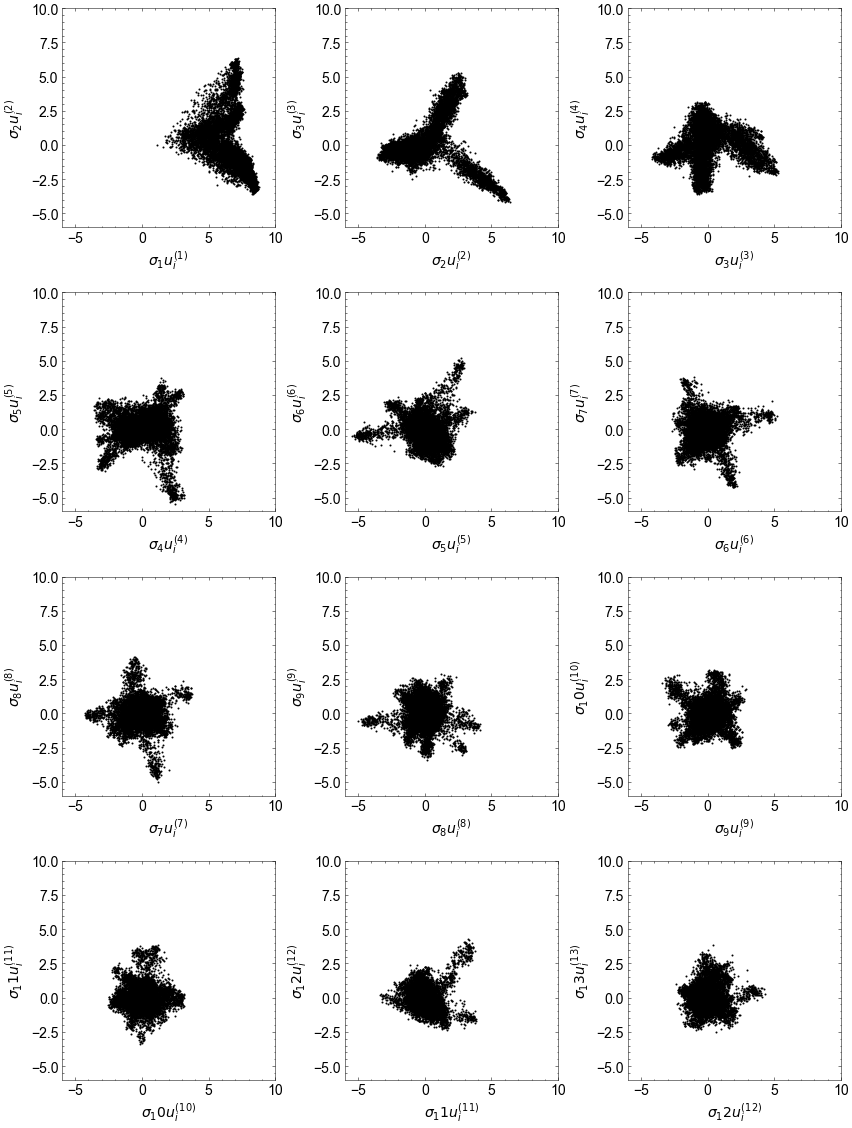

In [30]:
fig = plt.figure(figsize=(12,16))

for i in range(12):
    plt.subplot(4, 3, i+1)
    plt.xlim(-6, 10)
    plt.ylim(-6, 10)
    plt.plot(S[i]*U[:,i], S[i+1]*U[:,i+1], 'ok', markersize=1)
    plt.xlabel(f'$\sigma_{i+1} u_i^{{({i+1})}}$')
    plt.ylabel(f'$\sigma_{i+2} u_i^{{({i+2})}}$')
    
plt.tight_layout()
plt.savefig(f'{PROTEIN_NAME}_SigmaU_12_2dplots_nocluster.pdf')

### 3D plots of sequences along the first three singular axes

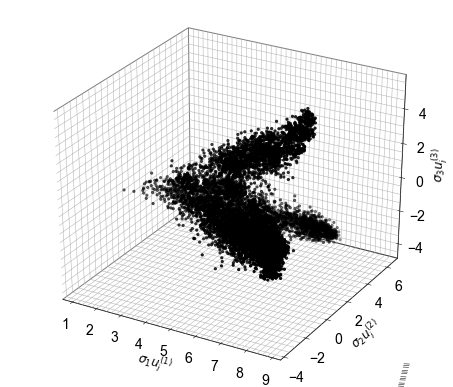

In [32]:
fig = plt.figure(1, figsize = (8, 7))
ax = fig.add_subplot(projection='3d')

ax.set_xlabel(f"$\sigma_{{{1}}} u_i^{{({1})}}$", fontsize=12)
ax.set_ylabel(f"$\sigma_{{{2}}} u_i^{{({2})}}$", fontsize=12)
ax.set_zlabel(f"$\sigma_{{{3}}} u_i^{{({3})}}$", fontsize=12)

ax.scatter(S[0]*U[:,0], S[1]*U[:,1], S[2]*U[:,2], c = 'black', s = 5)

# Get rid of colored axes planes
# First remove fill
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Now set color to white (or whatever is "invisible")
ax.xaxis.pane.set_edgecolor('black')
ax.yaxis.pane.set_edgecolor('black')
ax.zaxis.pane.set_edgecolor('black')

ax.view_init(30,300)

## Analysis of residues in SVD space
### Just plot $v_i^{{({k})}}$ values, no $\sigma 's$.

### First 2D plots:

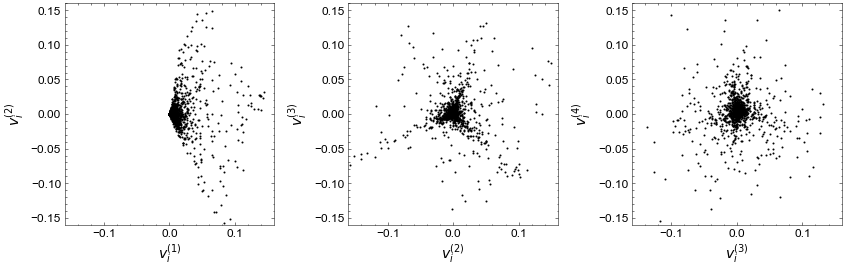

In [33]:
mpl.rc('font', family='Arial', size=12)
fig = plt.figure(figsize=(12,4))

for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.xlim(-0.16, 0.16)
    plt.ylim(-0.16, 0.16)
    plt.plot(V[:,i], V[:,i+1], 'ok',markersize=1)
    plt.xlabel(f'$v_i^{{({i+1})}}$', fontsize=14)
    plt.ylabel(f'$v_i^{{({i+2})}}$', fontsize=14)

plt.tight_layout()
plt.savefig(f'{PROTEIN_NAME}_V_3_2dplots_nocluster.pdf')

### Now a 3D plot

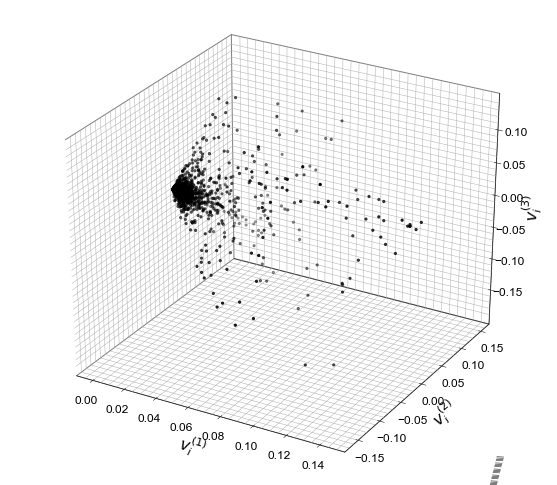

In [36]:
mpl.rc('font', family='Arial', size=12)
fig = plt.figure(1, figsize = (8, 7))
ax = fig.add_subplot(projection='3d')

ax.set_xlabel(f"$v_i^{{({1})}}$", fontsize=16)
ax.set_ylabel(f"$v_i^{{({2})}}$", fontsize=16)
ax.set_zlabel(f"$v_i^{{({3})}}$", fontsize=16)

ax.scatter(V[:,0], V[:,1], V[:,2], c = 'black', s = 5)

# Get rid of colored axes planes
# First remove fill
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Now set color to white (or whatever is "invisible")
ax.xaxis.pane.set_edgecolor('black')
ax.yaxis.pane.set_edgecolor('black')
ax.zaxis.pane.set_edgecolor('black')

ax.view_init(30,300)

plt.tight_layout()
plt.savefig(f'{PROTEIN_NAME}_SigmaV_3_3dplots_cluster.pdf')

# Create movie of the 3D plot
MOVIES = 0
if MOVIES == 1:
    imagedata = []
    for ii in range(0,360,1):
        # create temporary frame for movie
        ax.view_init(30, azim=ii)
        plt.savefig('movie%d.png' % ii)
        
        # save temporary frame for movie
        data = imageio.imread('movie{}.png'.format(ii))
        data = cv2.resize(data, (960, 960))
        imagedata.append(data)
        
        # remove temporary frame from directory
        os.remove('movie{}.png'.format(ii))

    imageio.mimwrite(f'{PROTEIN_NAME}_residues_black.mp4', imagedata, format= '.mp4', fps = 20)

## K-Means Clustering

### Elbow Method to Choose Number of Clusters

The WCSS is the sum of squared distance between each point and the centroid of a cluster. We use the elbow method to help inform our decision on the number of clusters. The goal is to minimize the WCSS without using more clusters than necessary. This is typically found at the "elbow" of the graph 

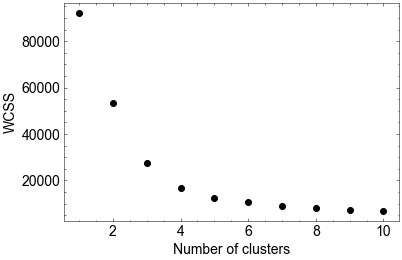

In [21]:
mpl.rc('font', family='Arial', size=14)
labelfont = {'family': 'Arial', 'size': 24}

wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(SU_df.iloc[:, 0:3])
    wcss.append(kmeans.inertia_)
    
plt.figure(figsize=(6, 4))
plt.plot(range(1, 11), wcss,'o',color='black')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

plt.savefig(f'{PROTEIN_NAME}_elbowplot.pdf')

### Parameters for clustering

In [22]:
# parameters for clustering
CLUSTERS = 4
cluster_ID_colormap = {0 : 'red', 1 : 'blue', 2: 'orange', 3: 'green', 4: 'black', 5: 'violet'}

### Perform K-Means clustering

In [23]:
kmeans = KMeans(n_clusters = CLUSTERS, init ='k-means++', 
                max_iter = 300, n_init = 10, random_state = 0)
cluster_ID = kmeans.fit_predict(SU_df.iloc[:, 0:3])
cluster_color = [cluster_ID_colormap[k] for k in cluster_ID]

### 2D plots of clustered sequences along the first three singular axes

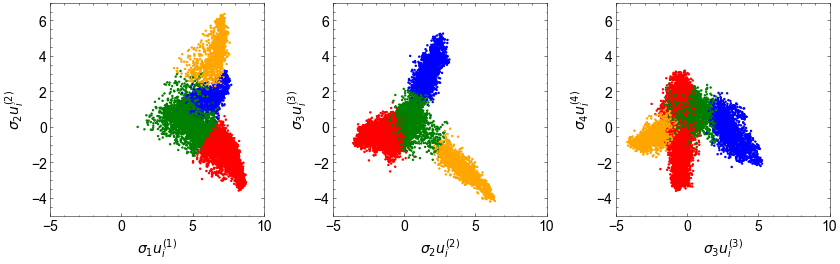

In [24]:
fig5 = plt.figure(figsize=(12,4))

for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.xlim(-5, 10)
    plt.ylim(-5, 7)
    plt.scatter(S[i]*U[:,i], S[i+1]*U[:,i+1], s = 2, c = cluster_color)
    plt.xlabel(f'$\sigma_{i+1} u_i^{{({i+1})}}$')
    plt.ylabel(f'$\sigma_{i+2} u_i^{{({i+2})}}$')

plt.tight_layout()
plt.savefig(f'{PROTEIN_NAME}_SigmaU_3_2dplots_cluster.pdf')

### 3D plot of sequences along the first three singular axes

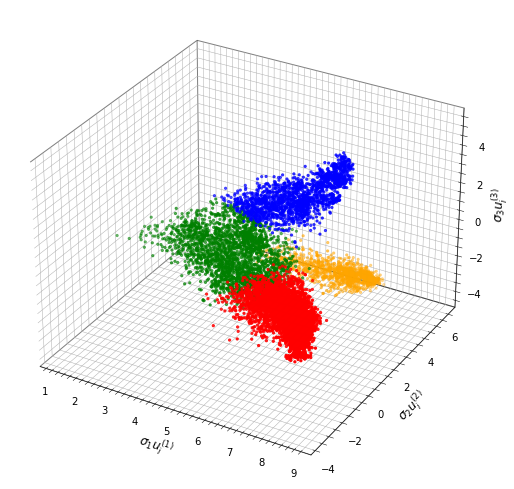

In [13]:
fig = plt.figure(1, figsize = (8, 7))
ax = fig.add_subplot(projection='3d')

ax.set_xlabel(f"$\sigma_{{{1}}} u_i^{{({1})}}$", fontsize=12)
ax.set_ylabel(f"$\sigma_{{{2}}} u_i^{{({2})}}$", fontsize=12)
ax.set_zlabel(f"$\sigma_{{{3}}} u_i^{{({3})}}$", fontsize=12)

ax.scatter(S[0]*U[:,0], S[1]*U[:,1], S[2]*U[:,2], c = cluster_color, s = 5)

# Get rid of colored axes planes
# First remove fill
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Now set color to white (or whatever is "invisible")
ax.xaxis.pane.set_edgecolor('black')
ax.yaxis.pane.set_edgecolor('black')
ax.zaxis.pane.set_edgecolor('black')

ax.view_init(30,300)

plt.tight_layout()
plt.savefig(f'{PROTEIN_NAME}_SigmaU_3_3dplots_cluster.pdf')

# Create movie of the 3D plot
MOVIES = 0
if MOVIES == 1:
    imagedata = []
    for ii in range(0,360,1):
        # create temporary frame for movie
        ax.view_init(30, azim=ii)
        plt.savefig('movie%d.png' % ii)
        
        # save temporary frame for movie
        data = imageio.imread('movie{}.png'.format(ii))
        data = cv2.resize(data, (960, 960))
        imagedata.append(data)
        
        # remove temporary frame from directory
        os.remove('movie{}.png'.format(ii))

    imageio.mimwrite(f'{PROTEIN_NAME}_kmeans.mp4', imagedata, format= '.mp4', fps = 20)

## Generating Consensus Sequences

To generate the consensus sequences, we take the most frequent residue at each position along the protein sequence. With the way we have constructed consensus, gaps have to be 50% or less at each position.

In [25]:
def create_consensus(sequences):
    listed_seqs = []

    for seq in sequences:
        listed_seqs.append(list(seq))

    seq_df = pd.DataFrame(listed_seqs)
    consensus = ''

    for i in range(len(sequences[0])):
        residues = seq_df[i].value_counts().index.tolist()
        freq = seq_df[i].value_counts()/float(seq_df.shape[0])
        if residues[0] == '-' and freq[0] < 0.5:
            consensus = consensus + residues[1]
        else:
            consensus = consensus + residues[0]

    return consensus

## Generate Consensus for the Entire MSA

In [26]:
cons_seq_all = (create_consensus(sequences))

In [51]:
cons_seq_all

'KVVLLGDSGVGKTSLLLRFVDGEFPEEYDPTIGVDFTKTVEVDGKTVKLQIWDTAGQERFRSLTRSYYRGADGALLVYDVTDRESFENVKKWLKEIRKHADPNVPIILVGNKSDLEDERQVSTEEGEALAKEGAKFFETSAKTGENVEEAFEELAREI'

## Generate a dictionary of the names (e.g., A0A1J4JHK3/1-112) in each cluster (keyed by color)

In [27]:
colors = list(cluster_ID_colormap.values())

names_in_color_dict = {c: [] for c in colors[:cluster_ID.max()+1]}

for j in range(len(cluster_ID)):
    label = cluster_ID_colormap[cluster_ID[j]]
    names_in_color_dict[label].append(names[j])

df = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in names_in_color_dict.items()]))
df.to_csv('{}_{}_clusters.csv'.format(PROTEIN_ABRV, str(CLUSTERS))) 

## Create consensus sequences for individual clusters

In [28]:
cons_seqs_clusters = []

for c in range(CLUSTERS):
    cluster_names = names_in_color_dict[colors[c]]

    seqs_in_cluster = []
    for name in cluster_names:
        id_seq = names.index(name)
        seqs_in_cluster.append(sequences[id_seq])
    
    cons_seqs_clusters.append(create_consensus(seqs_in_cluster))
    
    print(colors[c] + ': ' + cons_seqs_clusters[c] +'\n')
    ofile = open(PROTEIN_ABRV + '_clusters/' + PROTEIN_ABRV + '_' 
                 + str(CLUSTERS) + "_" + colors[c] + ".txt", "w")

    for i in range(len(cluster_names)):
        ofile.write(">" + cluster_names[i] + "\n" + seqs_in_cluster[i] + "\n")
    
    ofile.close()

red: KVVLIGDSGVGKTSLLLRFVDDTFSESYKSTIGVDFTKTIEVDGKTVKLQIWDTAGQERFRSITPSYYRGAHGAILVYDITNRESFENLKKWLKELRRHASPDVPIILVGNKCDLEDKRQVSTEEAEAFAEEGL-FFETSAKTGENVEEAFEELARKI

blue: KVVVLGSGGVGKSALTVQFVQGRF-EEYDPTI--EYRKQVVIDGEELDI-L-DTAGQEEFSAM-RDYIRTGDGFLLVYSITDRSSFEEIKE-LREIRK--DDDVPIVLVGNKCDLEDEREVSTEEGEALAKEGC-FIETSAKTNINVDEAFHELVREI

orange: KCVVVGDGAVGKTCLLISYTTNKFPEEY-PTV--DYVADVMVDGKPVELGLWDTAGQEDYDRL-RSY-PDTD-FLICFSVDSPDSLENVEKWI-EVRHHC-PGVPIILVGTKKDL---RQVTYEQGEALAKEGAKYLECSALTQEGVKEVFDEAIRAA

green: KIVVVGDSGVGKTSLIKRFVTGEFSEEYVPTIGVDFVKTVTIDGKEVKLQIWDTAGQERFRSLTRSYYRGADAVILVYDVTDRESFENLKKWLEEIRR---PNIPIVLVGNKSDL-DERQVSEEEAEEFAKEGIPYFETSAKTGENVEELFEELAKA-



## Project consensus sequences into SVD space

To project the conesnsus sequences into SVD space, we take the product between the one-hot encoding of the consensus sequences and the residue eigenvector matrix V.

In [29]:
cons_all_ohe = ohe(cons_seq_all)
cons_all_sigmau_coords = np.matmul(cons_all_ohe, V)

cons_clusters_sigmau_coords = np.zeros([CLUSTERS, len(V)])

for i in range(len(cons_seqs_clusters)):
    cons_ohe = ohe(cons_seqs_clusters[i])
    cons_clusters_sigmau_coords[i, :] = np.matmul(cons_ohe, V)

## Compare sigma1 u(1) values to matches to consensus.  Easiest to do with binary encodings.

In [56]:
idents_to_cons = np.zeros(len(sequences))

i = 0
while i < len(F):
    idents_to_cons[i] = np.dot(F[i,:], cons_all_ohe)
    i += 1

In [57]:
idents_to_cons

array([46., 24., 49., ..., 86., 34., 66.])

The correlation coefficient is (0.9731587274036657, 0.0).


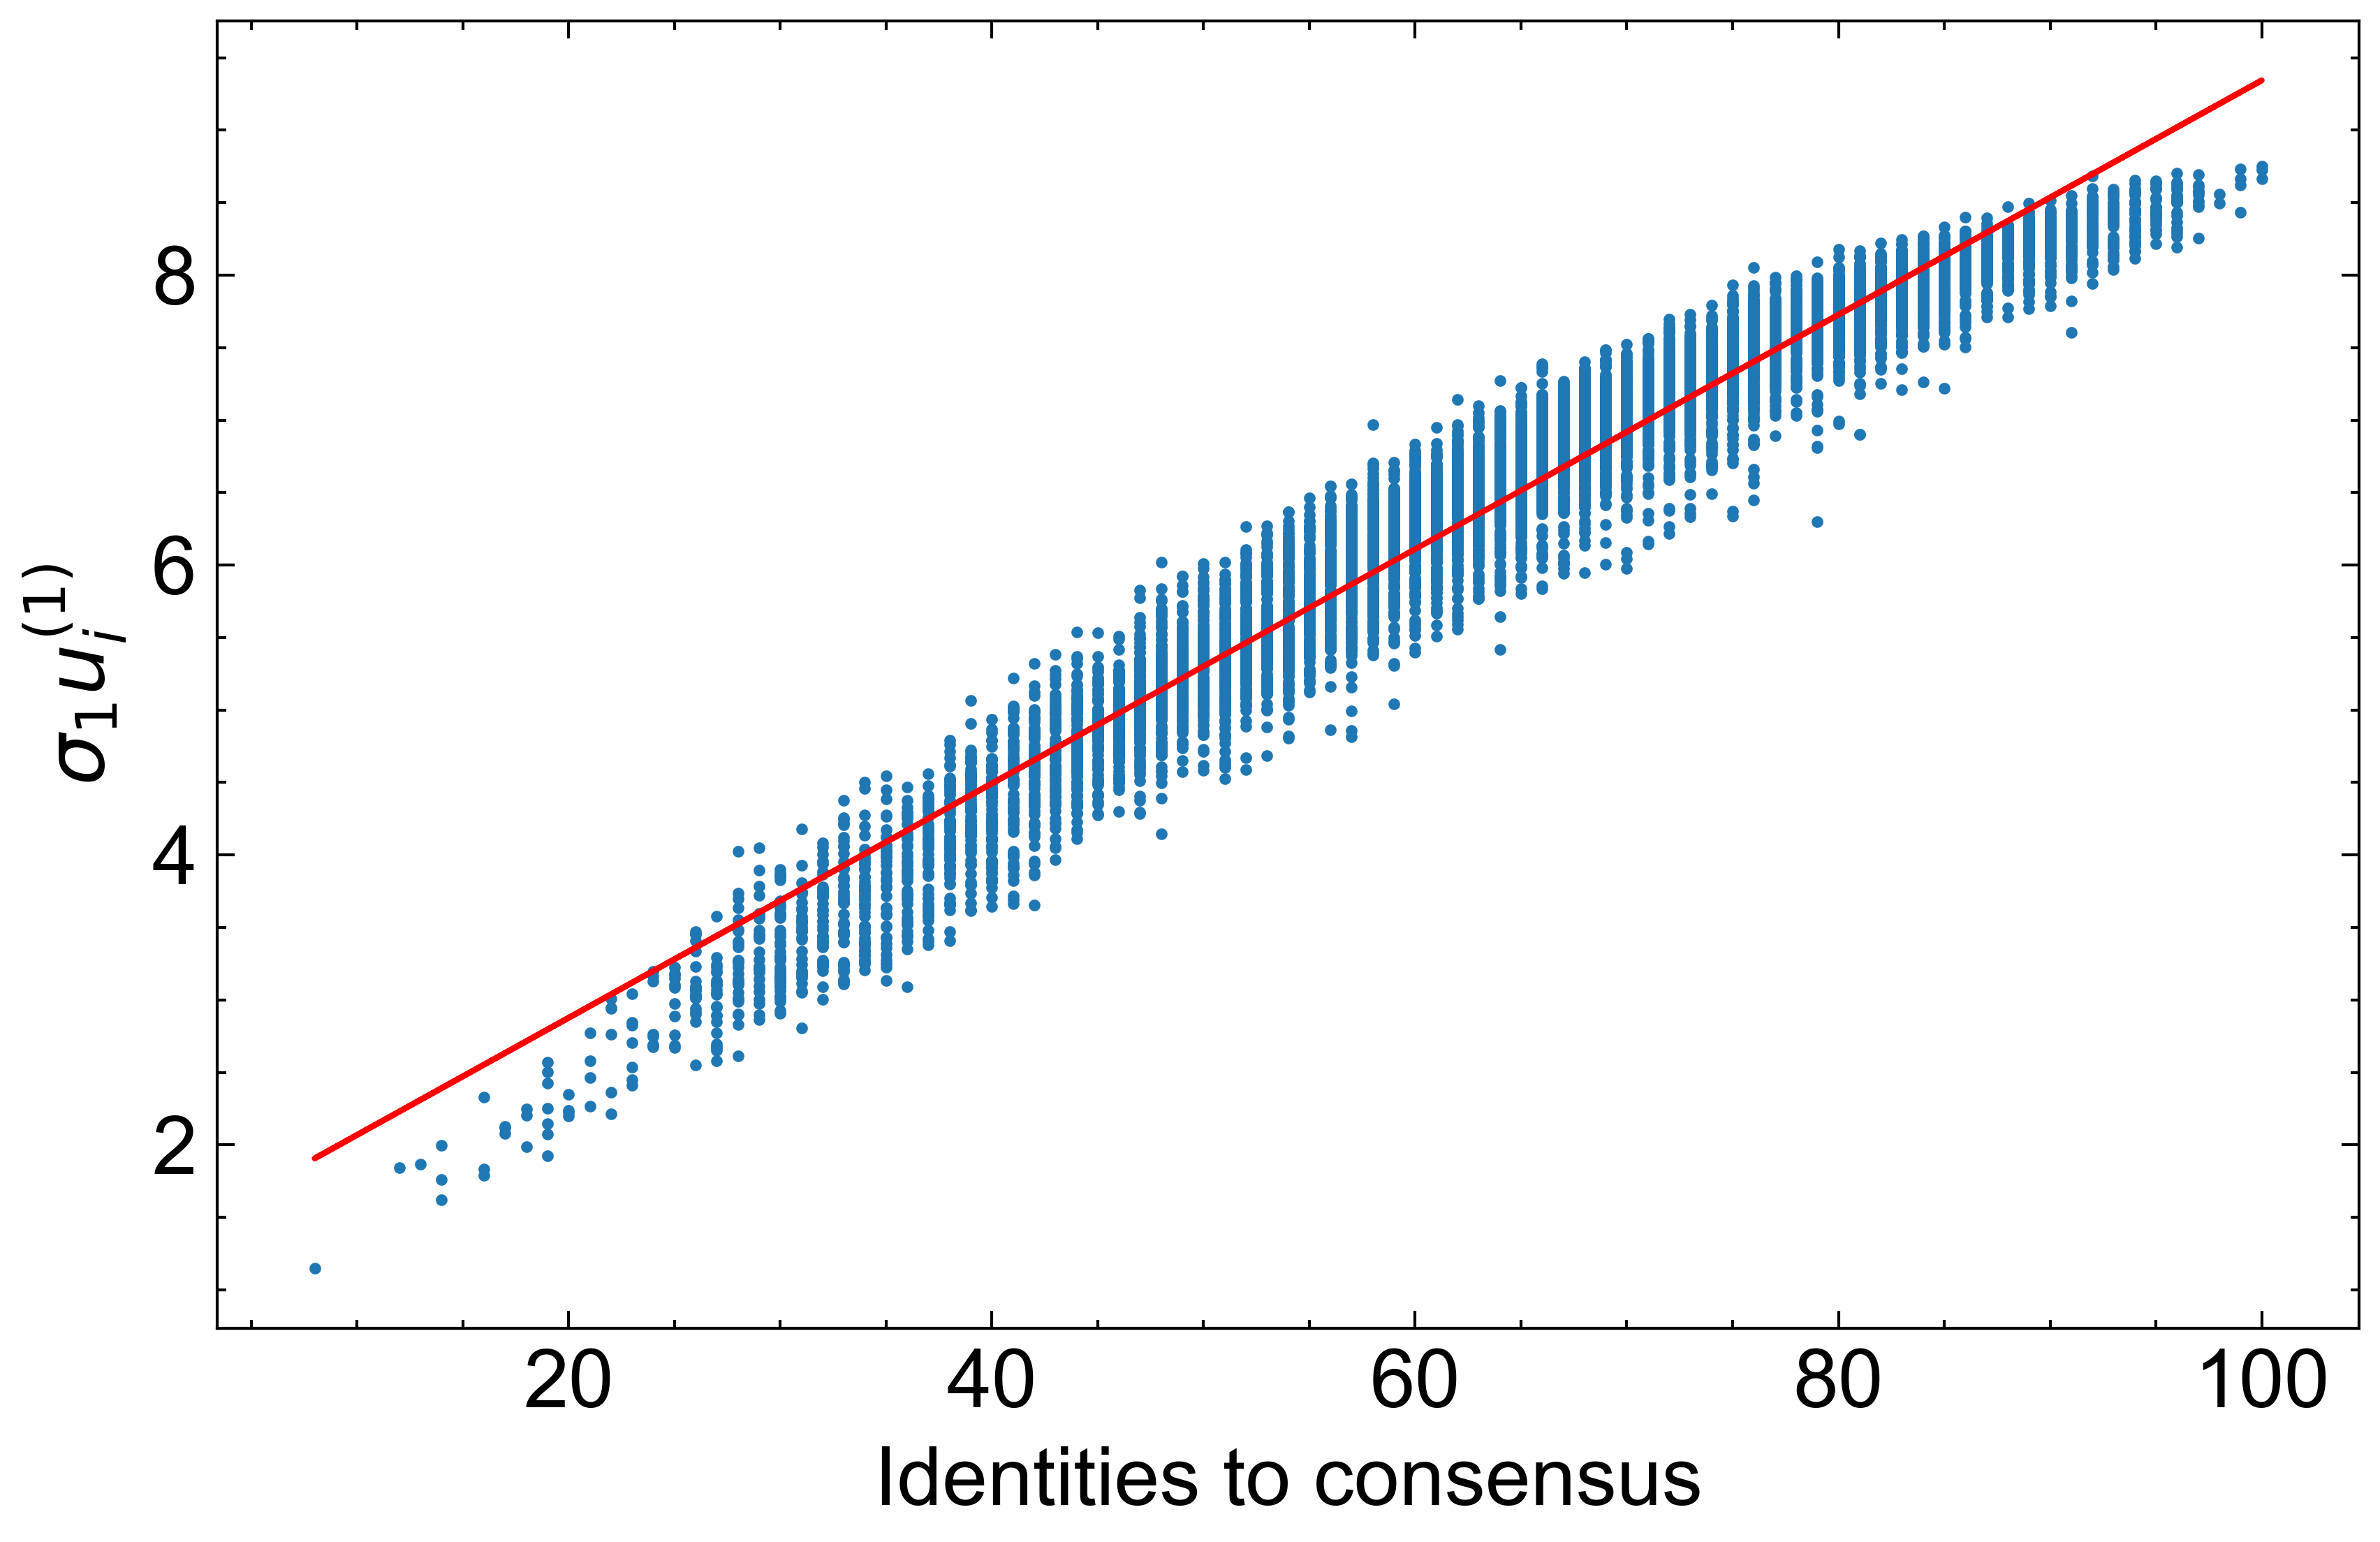

In [77]:
m, b = np.polyfit(idents_to_cons, S[0]*U[:, 0], 1)
pcc = sp.stats.pearsonr(idents_to_cons, S[0]*U[:, 0])
print(f'The correlation coefficient is {pcc}.')

fig5 = plt.figure(dpi=600)
plt.plot(idents_to_cons, S[0]*U[:,0], 'o', markersize = 1)
plt.plot(idents_to_cons, m*idents_to_cons + b, 'r')
plt.xlabel('Identities to consensus')
plt.ylabel(f'$\sigma_1 u_i^{{(1)}}$')

plt.tight_layout()
plt.savefig(f'{PROTEIN_NAME}_SigmaU_1_idents_cons.pdf')

## Plotting the Conensus Sequences in SVD space
MSA sequences are colored by their k-means cluster. The Pink star indicates the consensus sequence of the entire MSA. Colored squares show consensus sequences of each cluster

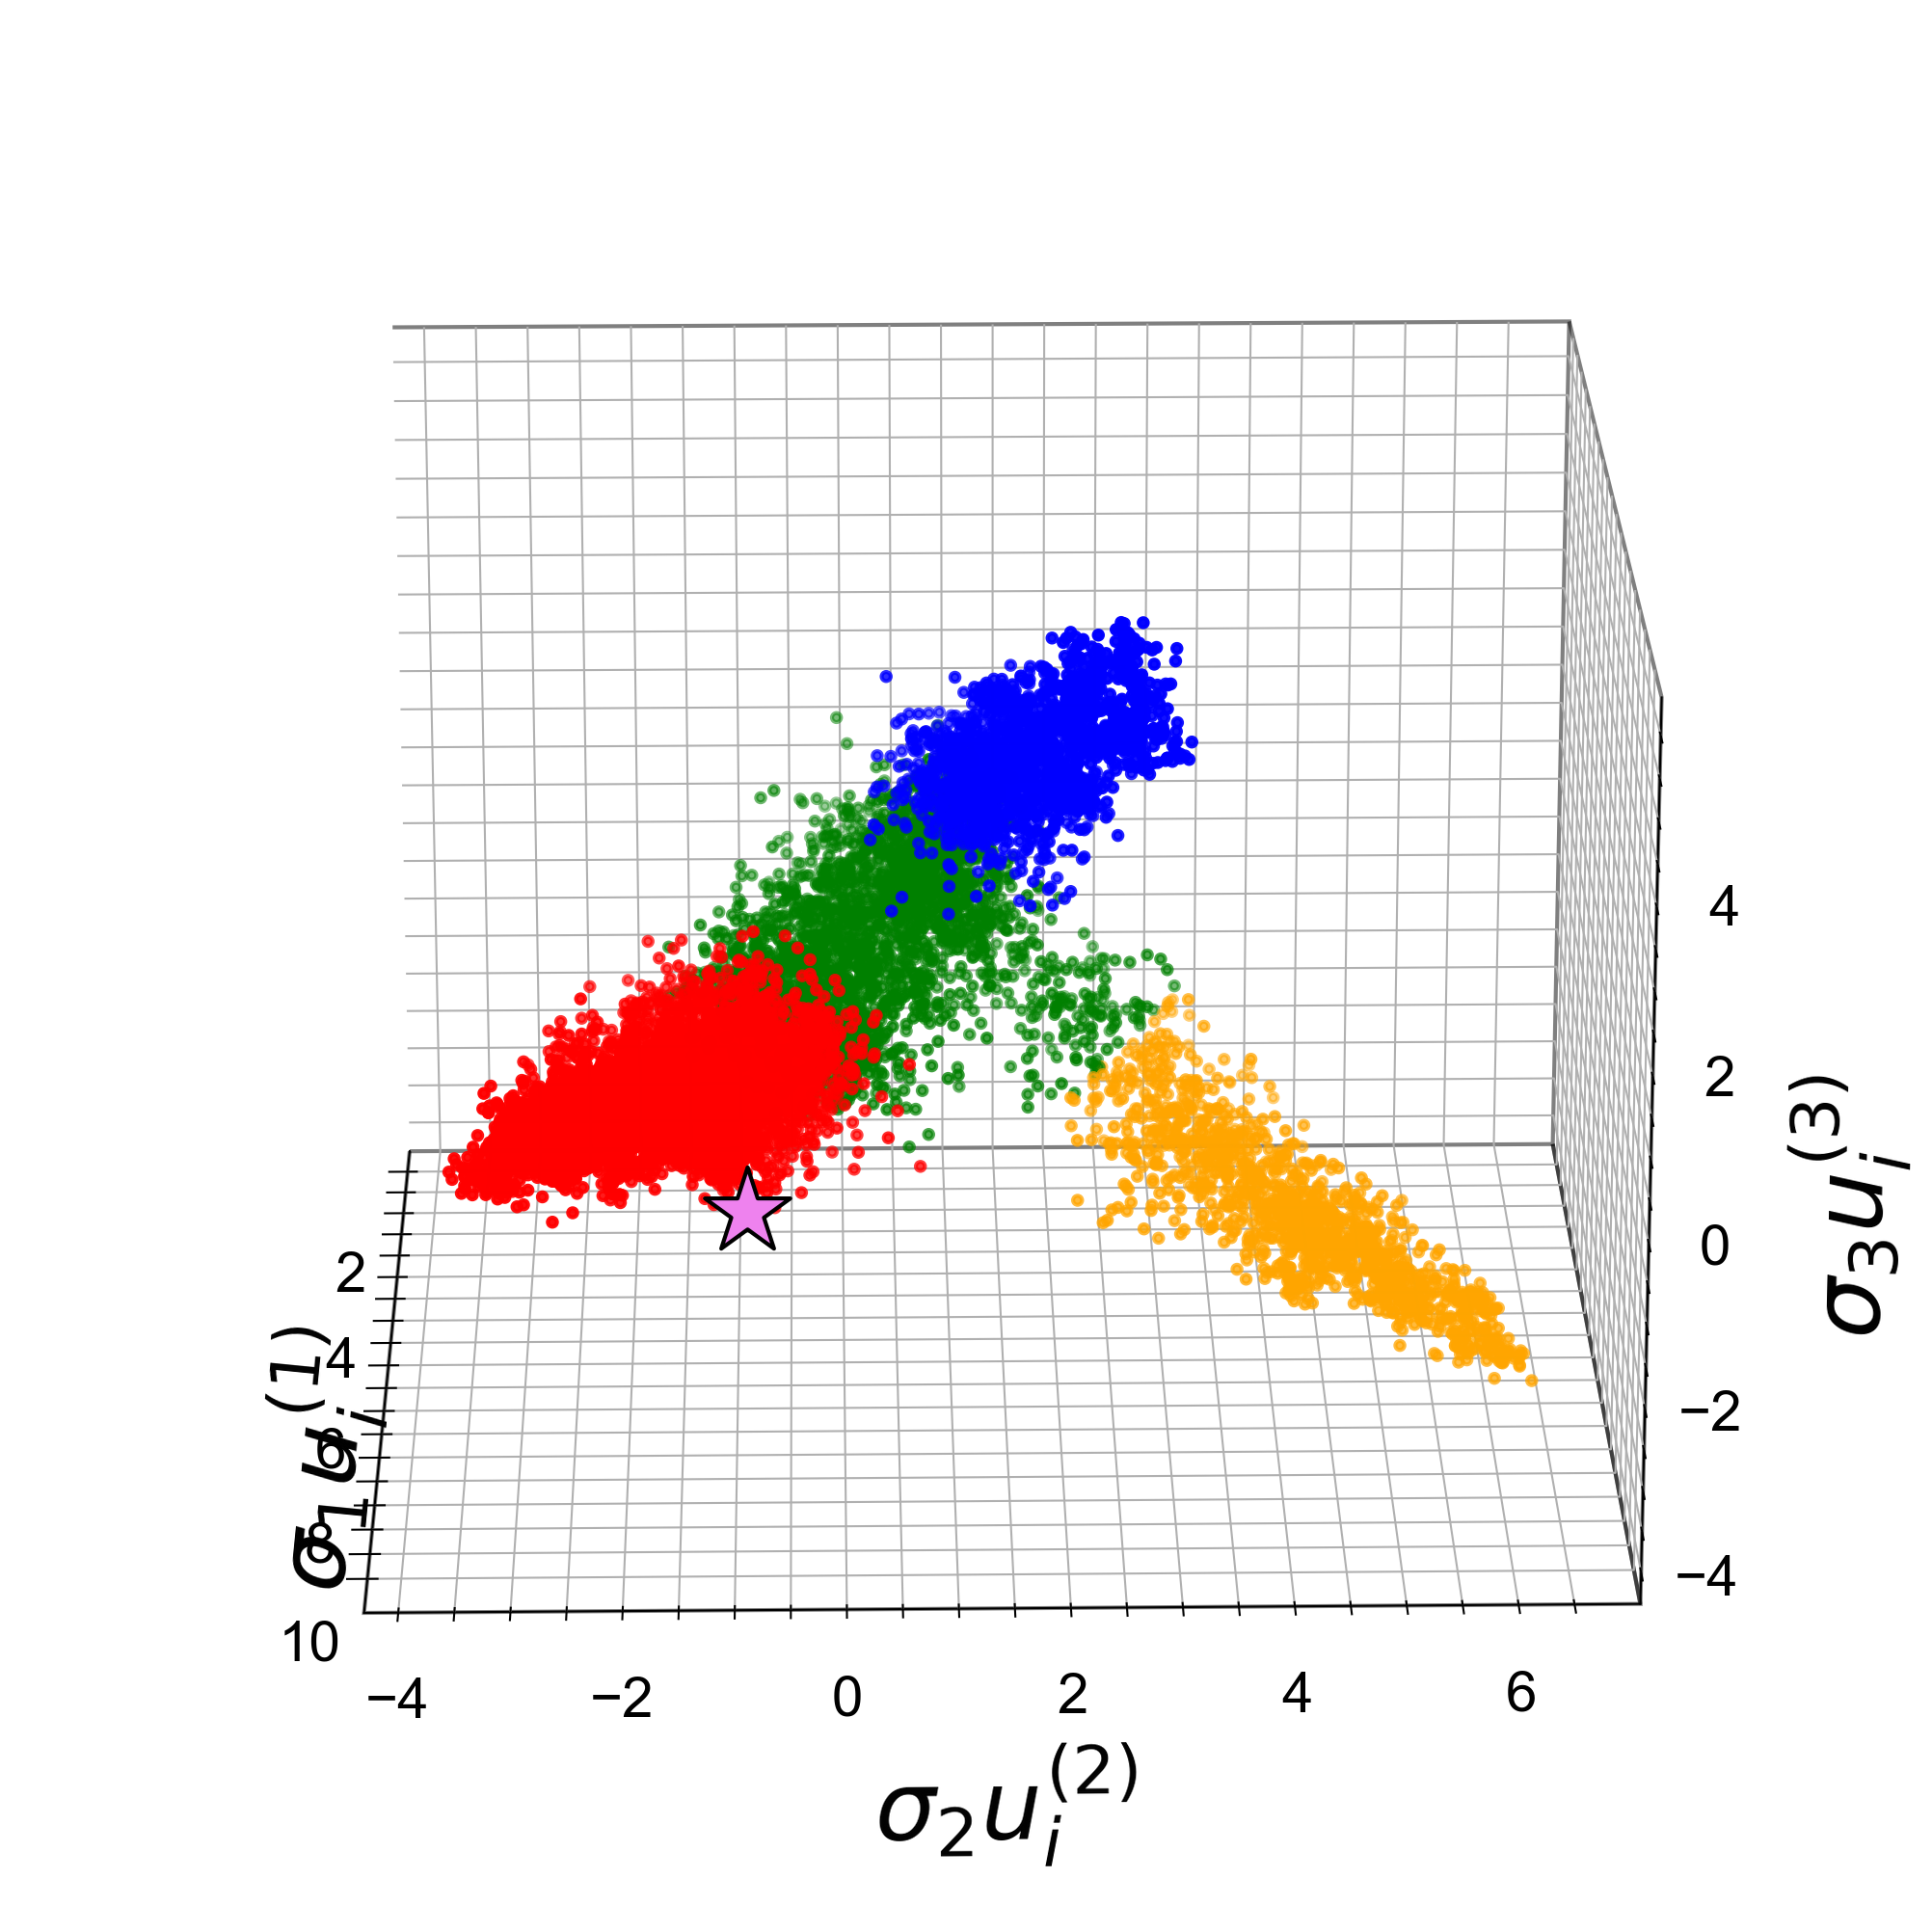

In [17]:
mpl.rc('font', family='Arial', size=14)
labelfont = {'family': 'Arial', 'size': 24}

fig = plt.figure(1, figsize = (8, 7), dpi=300)
ax = fig.add_subplot(projection='3d')

ax.set_xlabel(f"\n$\sigma_{{{1}}} u_i^{{({1})}}$", fontsize=24)
ax.set_ylabel(f"\n$\sigma_{{{2}}} u_i^{{({2})}}$", fontsize=24)
ax.set_zlabel(f"\n$\sigma_{{{3}}} u_i^{{({3})}}$", fontsize=24)

ax.scatter(S[0]*U[:,0], S[1]*U[:,1], S[2]*U[:,2], c = cluster_color, s = 5)

ax.scatter(cons_all_sigmau_coords[0], cons_all_sigmau_coords[1], cons_all_sigmau_coords[2],
               c = 'violet', s = 500, marker='*', edgecolors='k')
    
'''
for i in range(len(cons_seqs_clusters)):
    ax.scatter(cons_clusters_sigmau_coords[i,0], 
               cons_clusters_sigmau_coords[i,1], 
               cons_clusters_sigmau_coords[i,2],
               c = colors[i], s = 100, marker='s', edgecolors='k')
'''

# Get rid of colored axes planes
# First remove fill
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Now set color to white (or whatever is "invisible")
ax.xaxis.pane.set_edgecolor('black')
ax.yaxis.pane.set_edgecolor('black')
ax.zaxis.pane.set_edgecolor('black')

ax.view_init(30,300)

plt.tight_layout()
plt.savefig(f'{PROTEIN_NAME}_seqs_3d_cluster_mainClustConsensus.pdf')

# Create movie of the 3D plot
MOVIES = 1
if MOVIES == 1:
    
    imagedata = []
    
    for ii in range(0,360,1):
        # create temporary frame for movie
        ax.view_init(20, azim=ii)
        plt.savefig('movie%d.png' % ii)
        
        # save temporary frame for movie
        data = imageio.imread('movie{}.png'.format(ii))
        data = cv2.resize(data, (960, 960))
        imagedata.append(data)
        
        # remove temporary frame from directory
        os.remove('movie{}.png'.format(ii))

    imageio.mimwrite(f'{PROTEIN_NAME}_seqs_3d_cluster_mainClustConsensus.mp4', imagedata, format= '.mp4', fps = 20)

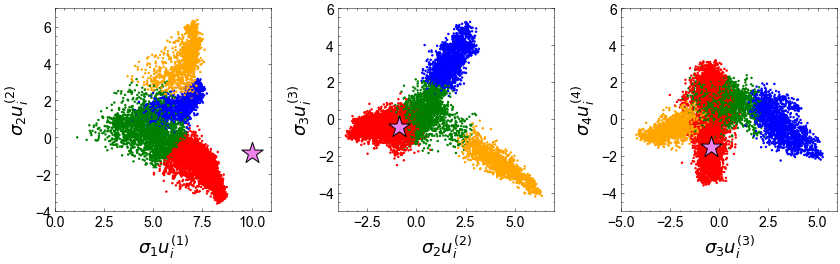

In [17]:
mpl.rc('font', family='Arial', size=14)
labelfont = {'family': 'Arial', 'size': 24}

fig = plt.figure(figsize=(12,4))

plt.subplot(1, 3, 1)
plt.xlim(0, 11)
plt.ylim(-4, 7)
plt.scatter(S[0]*U[:,0], S[1]*U[:,1], s = 2, c = cluster_color)
plt.scatter(cons_all_sigmau_coords[0], cons_all_sigmau_coords[1],
            c = 'violet', s = 500, marker='*', edgecolors='k')
plt.xlabel(f'$\sigma_{1} u_i^{{({1})}}$', fontsize=18)
plt.ylabel(f'$\sigma_{2} u_i^{{({2})}}$', fontsize=18)

plt.subplot(1, 3, 2)
plt.xlim(-4, 7)
plt.ylim(-5, 6)
plt.scatter(S[1]*U[:,1], S[2]*U[:,2], s = 2, c = cluster_color)
plt.scatter(cons_all_sigmau_coords[1], cons_all_sigmau_coords[2],
            c = 'violet', s = 500, marker='*', edgecolors='k')
plt.xlabel(f'$\sigma_{2} u_i^{{({2})}}$', fontsize=18)
plt.ylabel(f'$\sigma_{3} u_i^{{({3})}}$', fontsize=18)

plt.subplot(1, 3, 3)
plt.xlim(-5, 6)
plt.ylim(-5, 6)
plt.scatter(S[2]*U[:,2], S[3]*U[:,3], s = 2, c = cluster_color)
plt.scatter(cons_all_sigmau_coords[2], cons_all_sigmau_coords[3],
            c = 'violet', s = 500, marker='*', edgecolors='k')
plt.xlabel(f'$\sigma_{3} u_i^{{({3})}}$', fontsize=18)
plt.ylabel(f'$\sigma_{4} u_i^{{({4})}}$', fontsize=18)

plt.tight_layout()
plt.savefig(f'{PROTEIN_NAME}_SigmaU_3_2dplots_cluster_cons.pdf')

## Plot residues in SVD space, and color residues that are enrichied in a cluster according to that cluster's color.

The dictionary separates the F matrix into an F-matrix for each cluster (e.g., *F_cluster_1*). There is also a residue count for each cluster (e.g., *F_cluster_1_sum*) and a fraction (e.g., *F_cluster_1_fraction*), where the residue count is divided by the number of sequences in each cluster. The file is then saved for future runs. Once you have run it once, if you re-launch you can load the npy file and analyze it (because this cell takes a long time to run).

In addition, this dictionary contains the same information for sequences *not* in each cluster.

In [30]:
# dictionary of submatrices of F
F_cluster_dict = {}

for cluster in range(CLUSTERS):
    F_cluster_dict[f'F_cluster_{cluster}'] = np.array([])
    F_cluster_dict[f'F_cluster_{cluster}_sum'] = np.zeros(len(F[0]))
    F_cluster_dict[f'F_not_cluster_{cluster}'] = np.array([])
    F_cluster_dict[f'F_not_cluster_{cluster}_sum'] = np.zeros(len(F[0]))
    cluster_count = 0

    for seq_number in range(len(F)):
        if cluster_ID[seq_number] == cluster:
            F_cluster_dict[f'F_cluster_{cluster}']\
                = np.append(F_cluster_dict[f'F_cluster_{cluster}'], F[seq_number])
            F_cluster_dict[f'F_cluster_{cluster}_sum'] += F[seq_number]
            cluster_count += 1
        else:
            F_cluster_dict[f'F_not_cluster_{cluster}']\
                = np.append(F_cluster_dict[f'F_not_cluster_{cluster}'], F[seq_number])
            F_cluster_dict[f'F_not_cluster_{cluster}_sum'] += F[seq_number]
    
    # save residue count
    F_cluster_dict[f'F_cluster_{cluster}']\
       = F_cluster_dict[f'F_cluster_{cluster}'].reshape(cluster_count, len(F[seq_number]))
    F_cluster_dict[f'F_not_cluster_{cluster}']\
       = F_cluster_dict[f'F_not_cluster_{cluster}'].reshape(len(F) - cluster_count, len(F[seq_number]))
    
    # save frequency of residues in sequences
    F_cluster_dict[f'F_cluster_{cluster}_fraction'] = \
    F_cluster_dict[f'F_cluster_{cluster}_sum']/len(F_cluster_dict[f'F_cluster_{cluster}'])
    F_cluster_dict[f'F_not_cluster_{cluster}_fraction'] = \
    F_cluster_dict[f'F_not_cluster_{cluster}_sum']/len(F_cluster_dict[f'F_not_cluster_{cluster}'])
    
    #np.save(f'F_cluster_{cluster}_fraction', F_cluster_dict[f'F_cluster_{cluster}_fraction'])
    # Probably should do a JSON save here to save the whole dictionary.

### Next make plots showing the fraction of each residue (position/residue) for each cluster

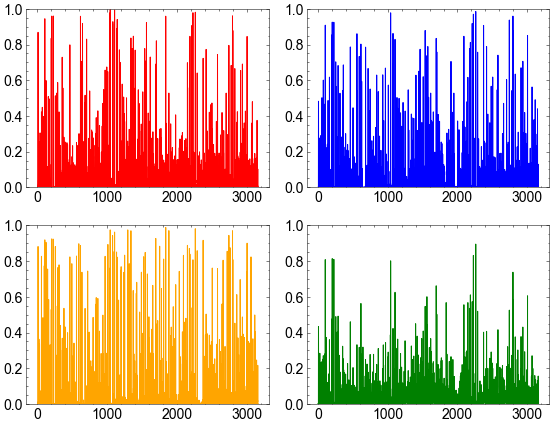

In [31]:
fig6 = plt.figure(figsize=(8,12))

for i in range(CLUSTERS):
    plt.subplot(4, 2, i+1)
    plt.plot(F_cluster_dict[f'F_cluster_{i}_fraction'], c = colors[i])
    plt.ylim(0, 1)

plt.tight_layout()

There are clear variations from one cluster to the next in the plots above.  These would be easier to identify as differences, that is, fraction in one cluster minus something out of cluster.  There are two ways to calculate these differences.  One is between one cluster and another cluster (there are many such comparisons--taking positive and negative differences as separate things, the number is $k^2 + k$).  This "difference pairs" method is calculated in another notebook.  Here we will take the difference between one cluster and everyting else.  Just looking at enhancements within a cluster, this leads to $k$ differences.

## General difference method.  Use threshold of 0.4 for now.

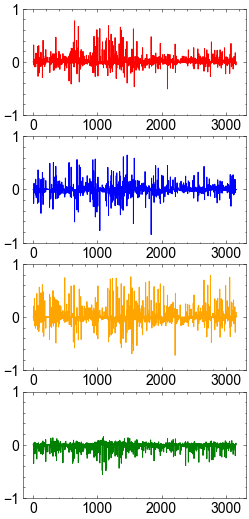

In [32]:
r_minus_not_r = F_cluster_dict[f'F_cluster_0_fraction'] - F_cluster_dict[f'F_not_cluster_0_fraction']
b_minus_not_b = F_cluster_dict[f'F_cluster_1_fraction'] - F_cluster_dict[f'F_not_cluster_1_fraction']
y_minus_not_y = F_cluster_dict[f'F_cluster_2_fraction'] - F_cluster_dict[f'F_not_cluster_2_fraction']
g_minus_not_g = F_cluster_dict[f'F_cluster_3_fraction'] - F_cluster_dict[f'F_not_cluster_3_fraction']

fig7 = plt.figure(figsize=(4,9))

plt.subplot(4, 1, 1)
plt.plot(r_minus_not_r, 'r')
plt.ylim((-1, 1))
plt.subplot(4, 1, 2)
plt.plot(b_minus_not_b, 'b')
plt.ylim((-1, 1))
plt.subplot(4, 1, 3)
plt.plot(y_minus_not_y, c = 'orange')
plt.ylim((-1, 1))
plt.subplot(4, 1, 4)
plt.plot(g_minus_not_g, 'g')
plt.ylim((-1, 1));



### Generate lists of residues where in-cluster frequency exceeds out-of-cluster frequency by threshold

In [33]:
threshold = 0.4

r_enriched = []
r_depleted = []
y_enriched = []
y_depleted = []
g_enriched = []
g_depleted = []
b_enriched = []
b_depleted = []### Generate lists of residues where in-cluster frequency exceeds out-of-cluster frequency by threshold
not_enriched = []

for resi in range(len(r_minus_not_r)):
    if r_minus_not_r[resi] > threshold:
        r_enriched.append(resi)
    #elif r_minus_not_r[resi] < threshold:
        #r_depleted.append(resi)

for resi in range(len(y_minus_not_y)):
    if y_minus_not_y[resi] > threshold:
        y_enriched.append(resi)
    #elif y_minus_not_y[resi] < threshold:
        #y_depleted.append(resi)

for resi in range(len(g_minus_not_g)):
    if g_minus_not_g[resi] > threshold:
        g_enriched.append(resi)
    #elif g_minus_not_g[resi] < threshold:
        #g_depleted.append(resi)
        
for resi in range(len(b_minus_not_b)):
    if b_minus_not_b[resi] > threshold:
        b_enriched.append(resi)
    #elif b_minus_not_b[resi] < threshold:
        #b_depleted.append(resi)

for resi in range(len(V)):
    if (r_minus_not_r[resi] < threshold) and (y_minus_not_y[resi] < threshold)\
    and (g_minus_not_g[resi] < threshold) and (b_minus_not_b[resi] < threshold):
        not_enriched.append(resi)
        
print(f'Number of residues enriched in red is {len(r_enriched)}.')
print(f'Number of residues enriched in yellow is {len(y_enriched)}.')
print(f'Number of residues enriched in green is {len(g_enriched)}.')
print(f'Number of residues enriched in blue is {len(b_enriched)}.')

Number of residues enriched in red is 20.
Number of residues enriched in yellow is 43.
Number of residues enriched in green is 0.
Number of residues enriched in blue is 19.


### Collect $v_i^{(k)}$ values for enriched residues in each cluster.

In [34]:
r_enriched_V = np.zeros((len(r_enriched), len(V.transpose())))

for i in range(len(r_enriched)):
    resi = r_enriched[i]
    r_enriched_V[i, :] = V[resi, :]

y_enriched_V = np.zeros((len(y_enriched), len(V.transpose())))

for i in range(len(y_enriched)):
    resi = y_enriched[i]
    y_enriched_V[i, :] = V[resi, :]

g_enriched_V = np.zeros((len(g_enriched), len(V.transpose())))

for i in range(len(g_enriched)):
    resi = g_enriched[i]
    g_enriched_V[i, :] = V[resi, :]

b_enriched_V = np.zeros((len(b_enriched), len(V.transpose())))

for i in range(len(b_enriched)):
    resi = b_enriched[i]
    b_enriched_V[i, :] = V[resi, :]

not_enriched_V = np.zeros((len(not_enriched), len(V.transpose())))

for i in range(len(not_enriched)):
    resi = not_enriched[i]
    not_enriched_V[i, :] = V[resi, :]

### Plot $v_i^{(k)}$ values for enriched and not-enriched residues.

#### 3D plot of cluster-enriched $v_i^{(k)}$ values along the first three singular axes

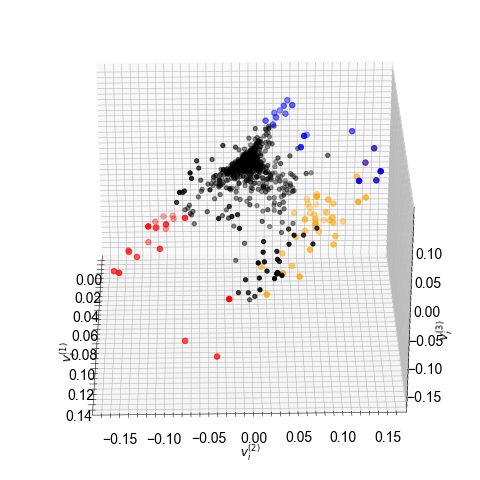

In [37]:
fig = plt.figure(1, figsize = (8, 7))
ax = fig.add_subplot(projection='3d')

ax.set_xlabel(f"$v_i^{{({1})}}$", fontsize=12)
ax.set_ylabel(f"$v_i^{{({2})}}$", fontsize=12)
ax.set_zlabel(f"$v_i^{{({3})}}$", fontsize=12)

ax.scatter(not_enriched_V[:, 0], not_enriched_V[:, 1], not_enriched_V[:, 2], c = 'k', s = 18)
ax.scatter(r_enriched_V[:, 0], r_enriched_V[:, 1], r_enriched_V[:, 2], c = 'r', s = 30)
ax.scatter(y_enriched_V[:, 0], y_enriched_V[:, 1], y_enriched_V[:, 2], c = 'orange', s = 30)
ax.scatter(g_enriched_V[:, 0], g_enriched_V[:, 1], g_enriched_V[:, 2], c = 'g', s = 30)
ax.scatter(b_enriched_V[:, 0], b_enriched_V[:, 1], b_enriched_V[:, 2], c = 'b', s = 30)

ax.view_init(30,300)

plt.tight_layout()
plt.savefig(f'{PROTEIN_NAME}_rygb_enriched_v_3dplots.pdf')

# Create movie of the 3D plot
MOVIES = 1
if MOVIES == 1:
    imagedata = []
    for ii in range(0,360,1):
        # create temporary frame for movie
        ax.view_init(30, azim=ii)
        plt.savefig('movie%d.png' % ii)
        
        # save temporary frame for movie
        data = imageio.imread('movie{}.png'.format(ii))
        data = cv2.resize(data, (960, 960))
        imagedata.append(data)
        
        # remove temporary frame from directory
        os.remove('movie{}.png'.format(ii))

    imageio.mimwrite(f'{PROTEIN_NAME}_rygb_enriched_v_3dplots.mp4', imagedata, format= '.mp4', fps = 20)

#### 2D plot of cluster-enriched $v_i^{(k)}$ values along the first four singular axes

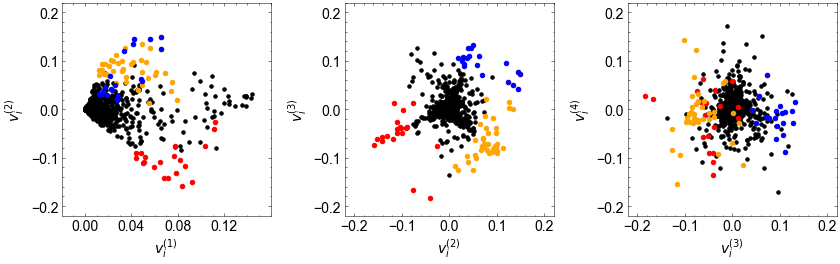

In [36]:
fig = plt.figure(figsize=(12,4))

plt.subplot(1, 3, 1)
plt.xlim(-0.02, 0.16)
plt.ylim(-0.22, 0.22)
plt.scatter(not_enriched_V[:, 0], not_enriched_V[:, 1], c = 'k', s = 12)
plt.scatter(r_enriched_V[:, 0], r_enriched_V[:, 1], c = 'r', s = 20)
plt.scatter(y_enriched_V[:, 0], y_enriched_V[:, 1], c = 'orange', s = 20)
plt.scatter(g_enriched_V[:, 0], g_enriched_V[:, 1], c = 'g', s = 20)
plt.scatter(b_enriched_V[:, 0], b_enriched_V[:, 1], c = 'b', s = 20)
plt.xticks([0.0, 0.04, 0.08, 0.12])
plt.yticks([-0.2, -0.1, 0.0, 0.1, 0.2])
plt.xlabel(f'$v_i^{{({1})}}$')
plt.ylabel(f'$v_i^{{({2})}}$')

plt.subplot(1, 3, 2)
plt.xlim(-0.22, 0.22)
plt.ylim(-0.22, 0.22)
plt.scatter(not_enriched_V[:, 1], not_enriched_V[:, 2], c = 'k', s = 12)
plt.scatter(r_enriched_V[:, 1], r_enriched_V[:, 2], c = 'r', s = 20)
plt.scatter(y_enriched_V[:, 1], y_enriched_V[:, 2], c = 'orange', s = 20)
plt.scatter(g_enriched_V[:, 1], g_enriched_V[:, 2], c = 'g', s = 20)
plt.scatter(b_enriched_V[:, 1], b_enriched_V[:, 2], c = 'b', s = 20)
plt.xticks([-0.2, -0.1, 0.0, 0.1, 0.2])
plt.yticks([-0.2, -0.1, 0.0, 0.1, 0.2])
plt.xlabel(f'$v_i^{{({2})}}$')
plt.ylabel(f'$v_i^{{({3})}}$')

plt.subplot(1, 3, 3)
plt.xlim(-0.22, 0.22)
plt.ylim(-0.22, 0.22)
plt.scatter(not_enriched_V[:, 2], not_enriched_V[:, 3], c = 'k', s = 12)
plt.scatter(r_enriched_V[:, 2], r_enriched_V[:, 3], c = 'r', s = 20)
plt.scatter(y_enriched_V[:, 2], y_enriched_V[:, 3], c = 'orange', s = 20)
plt.scatter(g_enriched_V[:, 2], g_enriched_V[:, 3], c = 'g', s = 20)
plt.scatter(b_enriched_V[:, 2], b_enriched_V[:, 3], c = 'b', s = 20)
plt.xticks([-0.2, -0.1, 0.0, 0.1, 0.2])
plt.yticks([-0.2, -0.1, 0.0, 0.1, 0.2])
plt.xlabel(f'$v_i^{{({3})}}$')
plt.ylabel(f'$v_i^{{({4})}}$')

plt.tight_layout()
plt.savefig(f'{PROTEIN_NAME}_rygb_enriched_v_2dplots.pdf')


### Plot $v_i^{(1)}$ versus frequency of each residue--strong correlation.

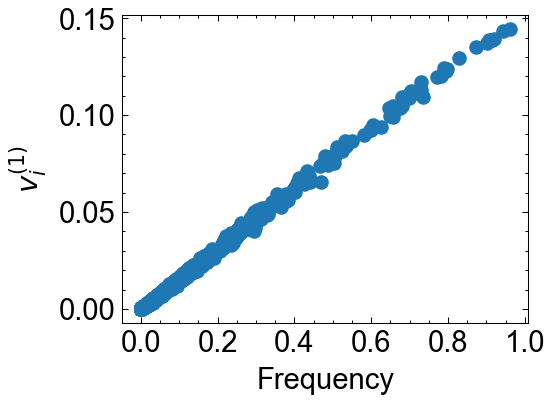

In [78]:
# Create an array that gives the frequency of each of the 20 l residues
F_freq = np.zeros(len(F.transpose()))
for resi in range(len(F.transpose())):
    F_freq[resi] = np.sum(F[:, resi])/len(F)

fig = plt.figure(figsize=(4,3), dpi=150)
plt.plot(F_freq, V[:, 0], 'o')
plt.xlabel('Frequency')
plt.ylabel('$v_i^{(1)}$')
plt.xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

plt.tight_layout()
plt.savefig(f'{PROTEIN_NAME}_Freq_vs_v(1).pdf')


### Showing that residues enriched in clusteres point in the same direction in $v_i^{(2)}$, $v_i^{(3)}$ space as $\sigma_2 u_i^{(2)}$, $\sigma_2 u_i^{(3)}$.

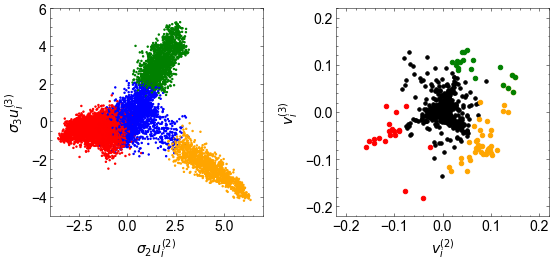

In [79]:
fig = plt.figure(figsize=(8,4))

plt.subplot(1, 2, 1)
plt.xlim(-4, 7)
plt.ylim(-5, 6)
plt.scatter(S[1]*U[:,1], S[2]*U[:,2], s = 2, c = cluster_color)
plt.xlabel(f'$\sigma_{2} u_i^{{({2})}}$')
plt.ylabel(f'$\sigma_{3} u_i^{{({3})}}$')

plt.subplot(1, 2, 2)
plt.xlim(-0.22, 0.22)
plt.ylim(-0.22, 0.22)
plt.scatter(not_enriched_V[:, 1], not_enriched_V[:, 2], c = 'k', s = 12)
plt.scatter(r_enriched_V[:, 1], r_enriched_V[:, 2], c = 'r', s = 20)
plt.scatter(y_enriched_V[:, 1], y_enriched_V[:, 2], c = 'orange', s = 20)
plt.scatter(g_enriched_V[:, 1], g_enriched_V[:, 2], c = 'g', s = 20)
plt.scatter(b_enriched_V[:, 1], b_enriched_V[:, 2], c = 'b', s = 20)
plt.xticks([-0.2, -0.1, 0.0, 0.1, 0.2])
plt.yticks([-0.2, -0.1, 0.0, 0.1, 0.2])
plt.xlabel(f'$v_i^{{({2})}}$')
plt.ylabel(f'$v_i^{{({3})}}$')

plt.tight_layout()
plt.savefig(f'{PROTEIN_NAME}_v23 su23_plots.pdf')

